# Project 5: Random Forests

Replicate figure 15.3 comparing random forests and gradient boosted trees. You can use whatever package you wish, you don't have to use xgboost if you'd rather keep everything in sci-kit learn. Compare the feature importance found by random forests and gradient boosted trees. If there are significant differences, can you offer an explanation? 

Select another dataset and repeat the analysis. Pick a dataset we have not yet studied in class.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from tqdm.notebook import tqdm
import kagglehub

## Functions

### Gradient Boosted Trees

In [55]:
class GradientBoostingAnalysis:
    def __init__(self, data, target_column, test_size=0.2):
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.model = None
        self.feature_importances_ = None
        self.results = None
        
        self.X = data.drop(columns=[target_column])
        self.y = data[target_column]
    
    def train_model(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=self.test_size
        )
        self.model = GradientBoostingRegressor()
        self.model.fit(X_train, y_train)
        
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        self.results = {"Mean Squared Error": mse, "R-squared": r2}
        return self.results
    
    def feature_analysis(self, top_n=10):
        if self.model is None:
            raise ValueError("The model must be trained before performing feature analysis.")
        
        feature_importances = pd.DataFrame({
            "Feature": self.X.columns,
            "Importance": self.model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
        top_features = feature_importances.head(top_n)
        plt.barh(top_features["Feature"], top_features["Importance"])
        plt.title("Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
        return feature_importances

### Random Forests

In [56]:
class RandomForestAnalysis:
    def __init__(self, data, target_column, test_size=0.2):
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.model = None
        self.feature_importances_ = None
        self.results = None
        
        self.X = data.drop(columns=[target_column])
        self.y = data[target_column]
    
    def train_model(self, n_estimators=100, max_depth=None):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=self.test_size
        )
        
        self.model = RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth
        )
        self.model.fit(X_train, y_train)
        
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        self.results = {"Mean Squared Error": mse, "R-squared": r2}
        return self.results
    
    def feature_analysis(self, top_n=10):
        if self.model is None:
            raise ValueError("The model must be trained before performing feature analysis.")
        
        feature_importances = pd.DataFrame({
            "Feature": self.X.columns,
            "Importance": self.model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
        top_features = feature_importances.head(top_n)
        plt.barh(top_features["Feature"], top_features["Importance"])
        plt.title("Feature Importance (Random Forest)")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
        return feature_importances

### Comparison

In [ ]:
def compare_models_on_num_trees(data, target_column, models, max_trees=1000, step=100, test_size=0.2):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    num_trees = np.arange(1, max_trees + 1, step)
    results = {model_name: [] for model_name in models}
    
    for n in tqdm(num_trees, desc="Evaluating models", unit="trees"):
        for model_name, model_fn in models.items():
            model = model_fn(n)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            mae = mean_absolute_error(y_test, predictions)
            results[model_name].append(mae)
    
    all_errors = np.concatenate([np.array(errors) for errors in results.values()])
    y_min = np.min(all_errors) * 0.99
    y_max = np.percentile(all_errors, 99)
    
    plt.figure(figsize=(12, 8))
    for model_name, errors in results.items():
        plt.plot(num_trees, errors, label=model_name, marker='o')
    plt.ylim(y_min, y_max)  # Set y-axis limits to 25th and 75th percentiles
    plt.xlabel("Number of Trees")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title("Model Comparison: MAE vs Number of Trees")
    plt.legend()
    plt.grid(True)
    plt.show()


## Analysis

### California Housing Dataset

In [58]:
california_housing = fetch_california_housing(as_frame=True)
california_housing_df = california_housing.frame
california_housing_target = "MedHouseVal"
california_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [59]:
ch_gb_model_analysis = GradientBoostingAnalysis(data=california_housing_df, target_column=california_housing_target)
ch_gb_results = ch_gb_model_analysis.train_model()
ch_gb_results

{'Mean Squared Error': np.float64(0.29610931606896435),
 'R-squared': 0.7791052894092831}

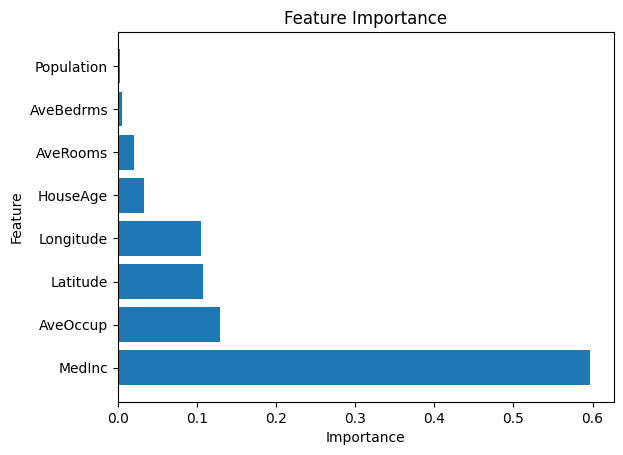

,Feature,Importance
0,MedInc,0.597115
5,AveOccup,0.128446
6,Latitude,0.107705
7,Longitude,0.105134
1,HouseAge,0.033203
2,AveRooms,0.020597
3,AveBedrms,0.004929
4,Population,0.002872


In [60]:
ch_gb_feature_importances = ch_gb_model_analysis.feature_analysis(top_n=10)
ch_gb_feature_importances

In [61]:
ch_rf_analysis = RandomForestAnalysis(data=california_housing_df, target_column=california_housing_target)
ch_rf_results = ch_rf_analysis.train_model(n_estimators=200, max_depth=10)
ch_rf_results

{'Mean Squared Error': np.float64(0.2965344994073311),
 'R-squared': 0.7785409727473456}

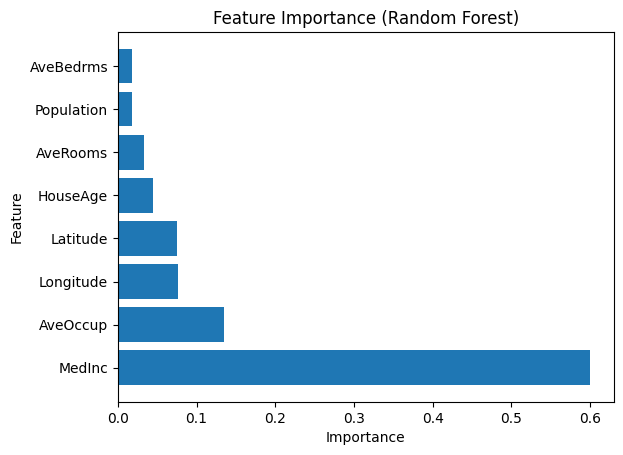

,Feature,Importance
0,MedInc,0.600101
5,AveOccup,0.135210
7,Longitude,0.075851
6,Latitude,0.075259
1,HouseAge,0.045081
2,AveRooms,0.033315
4,Population,0.017718
3,AveBedrms,0.017466


In [62]:
ch_rf_feature_importances = ch_rf_analysis.feature_analysis(top_n=10)
ch_rf_feature_importances

Evaluating models:   0%|          | 0/50 [00:00<?, ?trees/s]

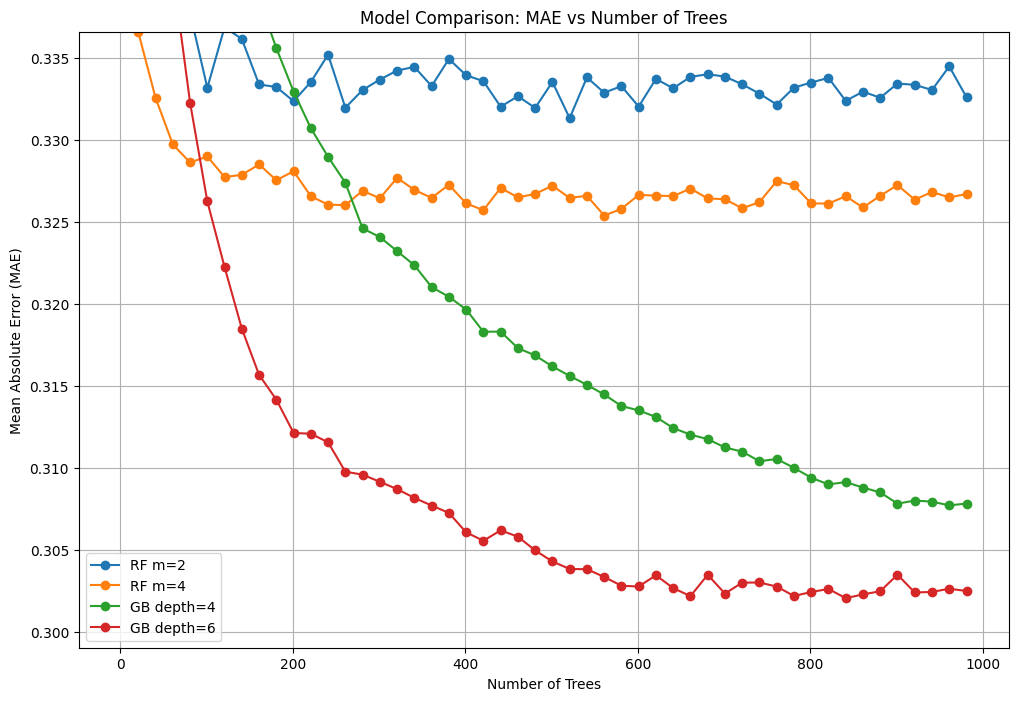

In [63]:
models_to_compare = {
    "RF m=2": lambda n: RandomForestRegressor(n_estimators=n, max_features=2),
    "RF m=4": lambda n: RandomForestRegressor(n_estimators=n, max_features=4),
    "GB depth=4": lambda n: GradientBoostingRegressor(n_estimators=n, max_depth=4),
    "GB depth=6": lambda n: GradientBoostingRegressor(n_estimators=n, max_depth=6)
}

compare_models_on_num_trees(
    data=california_housing_df, 
    target_column=california_housing_target, 
    models=models_to_compare,
    max_trees=1000, 
    step=20
)

### Insurance Dataset

In [64]:
insurance_path = kagglehub.dataset_download("mirichoi0218/insurance")
insurance_df = pd.read_csv(insurance_path + "/insurance.csv")
insurance_target = "charges"
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [65]:
insurance_df = pd.get_dummies(insurance_df, drop_first=True)
insurance_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [66]:
ic_gb_model_analysis = GradientBoostingAnalysis(data=insurance_df, target_column=insurance_target)
ic_gb_results = ic_gb_model_analysis.train_model()
ic_gb_results

{'Mean Squared Error': np.float64(18647426.540753122),
 'R-squared': 0.8258844968796863}

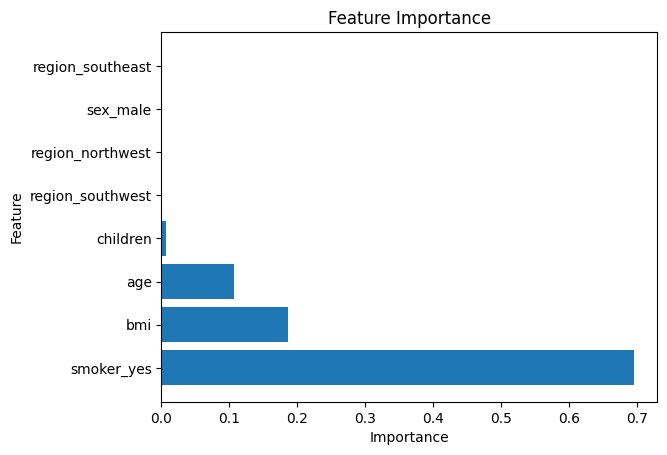

,Feature,Importance
4,smoker_yes,0.695189
1,bmi,0.186420
0,age,0.106300
2,children,0.007440
7,region_southwest,0.001503
5,region_northwest,0.001494
3,sex_male,0.001149
6,region_southeast,0.000506


In [67]:
ic_gb_feature_importances = ic_gb_model_analysis.feature_analysis(top_n=10)
ic_gb_feature_importances

In [68]:
ic_rf_analysis = RandomForestAnalysis(data=insurance_df, target_column=insurance_target)
ic_rf_results = ic_rf_analysis.train_model(n_estimators=200, max_depth=10)
ic_rf_results

{'Mean Squared Error': np.float64(14834392.99793578),
 'R-squared': 0.8689989880158697}

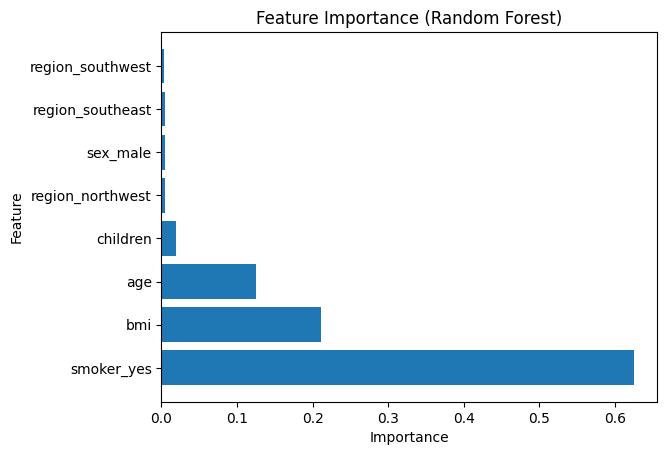

,Feature,Importance
4,smoker_yes,0.624730
1,bmi,0.210750
0,age,0.125267
2,children,0.019935
5,region_northwest,0.005411
3,sex_male,0.005255
6,region_southeast,0.004844
7,region_southwest,0.003808


In [69]:
ic_rf_feature_importances = ic_rf_analysis.feature_analysis(top_n=10)
ic_rf_feature_importances

Evaluating models:   0%|          | 0/50 [00:00<?, ?trees/s]

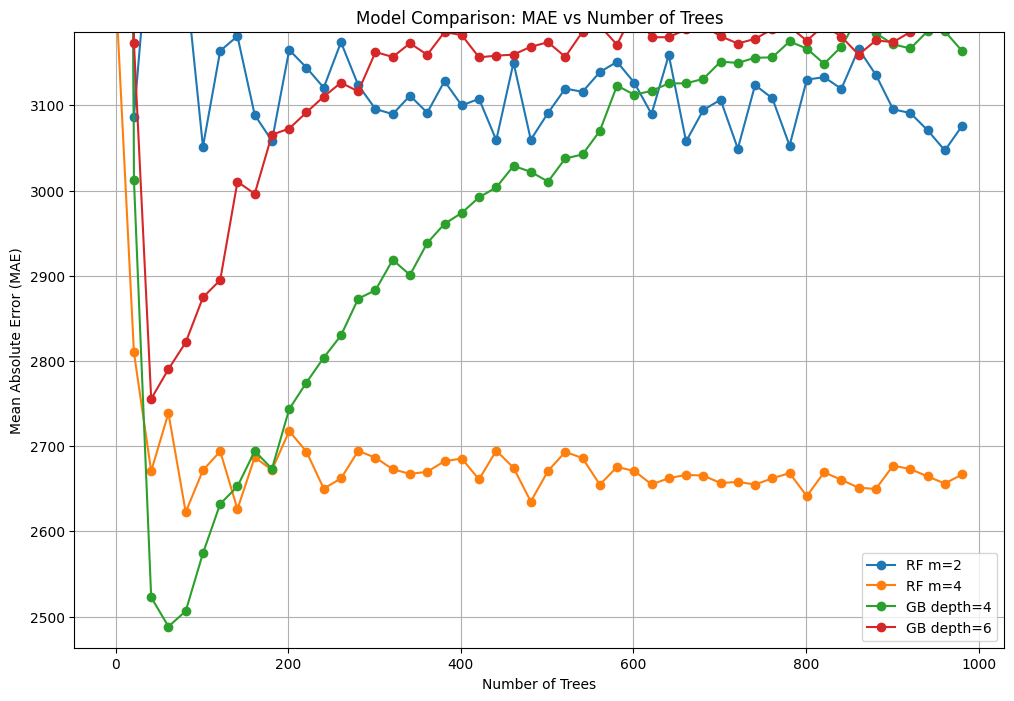

In [70]:
models_to_compare = {
    "RF m=2": lambda n: RandomForestRegressor(n_estimators=n, max_features=2),
    "RF m=4": lambda n: RandomForestRegressor(n_estimators=n, max_features=4),
    "GB depth=4": lambda n: GradientBoostingRegressor(n_estimators=n, max_depth=4),
    "GB depth=6": lambda n: GradientBoostingRegressor(n_estimators=n, max_depth=6)
}

compare_models_on_num_trees(
    data=insurance_df, 
    target_column=insurance_target, 
    models=models_to_compare,
    max_trees=1000, 
    step=20
)